<a href="https://colab.research.google.com/github/ltdaovn/analog-meter-reading-openCV/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

!pip install keras
!pip install tensorflow  
!pip3 install opencv-python
!pip install pypng
!pip install matplotlib


from google.colab.patches import cv2_imshow
from skimage import data,filters
from PIL import ImageTk, Image


import cv2
import csv
import matplotlib.pyplot as plt
import matplotlib.pylab as plt
import matplotlib.cm as cm
import numpy as np
import pathlib
import PIL
import os,png,array
import pandas as pd
import time

In [ ]:
!wget https://github.com/ltdaovn/analog-meter-reading-openCV/raw/main/cnn_svhn_.model

In [ ]:
#!wget "https://github.com/ltdaovn/analog-meter-reading-openCV/raw/main/easy_samples.zip"

In [ ]:
#!wget "https://github.com/ltdaovn/analog-meter-reading-openCV/raw/main/images.zip"

In [ ]:
#!unzip easy_samples.zip

In [ ]:
#!unzip images.zip

10120.png SAYAÇ MİKTAR: 22083None
10431.png SAYAÇ MİKTAR: 40013None
10545.png SAYAÇ MİKTAR: 481197
10370.png SAYAÇ MİKTAR: 34661None
10049.png SAYAÇ MİKTAR: 4748NoneNone
10104.png SAYAÇ MİKTAR: 21065None
10861.png SAYAÇ MİKTAR: 6682NoneNone
10803.png SAYAÇ MİKTAR: 6359NoneNone
10061.png SAYAÇ MİKTAR: 48113None
102.png SAYAÇ MİKTAR: 2069NoneNone
10496.png SAYAÇ MİKTAR: 43926None
10736.png SAYAÇ MİKTAR: 54969None
10361.png SAYAÇ MİKTAR: 36126None
10205.png SAYAÇ MİKTAR: 26970None
10510.png SAYAÇ MİKTAR: 474781
10130.png SAYAÇ MİKTAR: 2269NoneNone
1042.png SAYAÇ MİKTAR: 7878NoneNone
10321.png SAYAÇ MİKTAR: 344018
10453.png SAYAÇ MİKTAR: 41362None
10716.png SAYAÇ MİKTAR: 58454None
1083.png SAYAÇ MİKTAR: 61653None
10303.png SAYAÇ MİKTAR: 4266NoneNone
10151.png SAYAÇ MİKTAR: 23990None
10017.png SAYAÇ MİKTAR: 145422
10237.png SAYAÇ MİKTAR: 28806None
10076.png SAYAÇ MİKTAR: 4917NoneNone
10805.png SAYAÇ MİKTAR: 63617None
10068.png SAYAÇ MİKTAR: 148640
10338.png SAYAÇ MİKTAR: 344966
10473.png SA

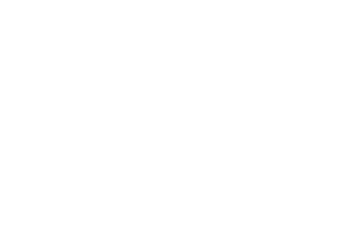

In [62]:
from keras.models import load_model
classifier=load_model('cnn_svhn_.model')

row_list = []
index_counter = 0
resize_counter = 0

directory="easy_samples/"
#directory="images/"

for file in os.listdir(directory):
  path = directory + file
  #print(path)
  try:
    #if (file=="SAYAC (7).jpg"): 
    if (file.endswith(".jpg") or file.endswith(".png")): 
        img = cv2.imread(path, 0)

        #cv2_imshow(img)

        if img is not None:
            #blur = cv2.GaussianBlur(grey, value, 0)
            img = cv2.GaussianBlur(img, (3,3), 0)

        #edges = cv2.Canny(img, 175, 200, apertureSize=3, L2gradient=False)
        def auto_canny(image, sigma=0.33):

            v = np.median(image)
            lower = int(max(0, (1.0 - sigma) * v))
            upper = int(min(255, (1.0 + sigma) * v))
            edged = cv2.Canny(image, lower, upper, apertureSize=3, L2gradient=True)
            return edged

        #edges = auto_canny(img)
        edges = cv2.Canny(img, 50, 200, apertureSize=3, L2gradient=False)

        contours, hierarchy = cv2.findContours(edges.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        contours_dict = dict()
        for cont in contours:
            x, y, w, h = cv2.boundingRect(cont)
            area = cv2.contourArea(cont)
            if 20 < area and 20 < w and h > 10 :
                contours_dict[(x, y, w, h)] = cont

        contours_filtered = sorted(contours_dict.values(), key=cv2.boundingRect)
        blank_background = np.zeros_like(edges)
        img_contours = cv2.drawContours(blank_background, contours_filtered, -1, (255,255,255), thickness=2)

        #cv2.imshow(img_contours)
        #cv2_imshow(img_contours)


        def is_overlapping_horizontally(box1, box2):
            x1, _, w1, _ = box1
            x2, _, _, _ = box2
            if x1 > x2:
                return is_overlapping_horizontally(box2, box1)
            return (x2 - x1) < w1

        def merge(box1, box2):
            assert is_overlapping_horizontally(box1, box2)
            x1, y1, w1, h1 = box1
            x2, y2, w2, h2 = box2
            x = min(x1, x2)
            w = max(x1 + w1, x2 + w2) - x
            y = min(y1, y2)
            h = max(y1 + h1, y2 + h2) - y
            return (x, y, w, h)

        def windows(contours):
            boxes = []
            for cont in contours:
                box = cv2.boundingRect(cont)
                if not boxes:
                    boxes.append(box)
                else:
                    if is_overlapping_horizontally(boxes[-1], box):
                        last_box = boxes.pop()
                        merged_box = merge(box, last_box)
                        boxes.append(merged_box)
                    else:
                        boxes.append(box)
            return boxes

        boxes = windows(contours_filtered)
        len_boxes = len(boxes)

        for n in range(len_boxes):
          x, y, w, h = boxes[n]
          plt.axis('off')
          
          if y < 10:
              y = 10
          if x < 10:
              x = 10
              
          roi = img[y-10:y+h+5, x-10:x+w+5]
          roi = cv2.resize(roi,(32, 32),interpolation = cv2.INTER_AREA)
          a = str(n+1)
          cv2.imwrite('basamak'+a+'.png', roi)

        columnNames = list()

        for i in range(1024):
            pixel = 'pixel'
            pixel += str(i)
            columnNames.append(pixel)

        train_data = pd.DataFrame(columns = columnNames)

        for n in range(len_boxes):
            a = str(n+1)
            b='basamak'+a+'.png'
            img = Image.open(b)
            rawData = img.load()
            data = []
            for y in range(32):
                for x in range(32):
                    data.append(rawData[x,y])
            k = 0
            train_data.loc[0] = [data[k] for k in range(1024)]
            train_data = train_data.div(255)
            train_data.to_csv("train_converted"+a+".csv",index = False)


        w ={}
        for n in range(len_boxes):
            a = str(n+1)
            b = "train_converted"+a+".csv"
            x_pred = pd.read_csv(b)
            x_pred = x_pred.iloc[:,:].values.astype('float32')
            x_pred =x_pred.reshape(-1, 32, 32, 1)
            predictions=classifier.predict(x_pred)
            x = predictions[4]
            c = "predictions"+a
            w.update( {c : x.argmax()} )
        
        row = [file,  str(w.get("predictions1")) + 
               str(w.get("predictions2")) +  
               str(w.get("predictions3")) +
               str(w.get("predictions4")) +
               str(w.get("predictions5")) +
               str(w.get("predictions6")) ]

        row_list.append(row)

        print( file + " " + "SAYAÇ MİKTAR: " +
            str(w.get("predictions1")) + 
            str(w.get("predictions2")) +  
            str(w.get("predictions3")) +
            str(w.get("predictions4")) +
            str(w.get("predictions5")) +
            str(w.get("predictions6")) 
            )

        continue
        
    else:
        continue

  except IndexError:
    if IndexError:
      index_counter += 1
      #print(file + " " +'List index out of range error')
      #print('index count: ', index_counter)
      pass

  '''except:
    row = [file, "Resize Error"]
    resize_counter += 1
    print('resize count: ', resize_counter)
    print(file + " " + 'resize error')'''

In [45]:
print(row_list)

[['SAYAC (7).jpg', '000523']]


In [63]:
# Create a file for new predicted values, then write it
# update this csv each time you changed something in the code above 
# then follow these steps and calculate the accuracy, compare with other results
with open('analog_predicted_meter.csv', 'w', newline='') as file:
  writer = csv.writer(file)
  writer.writerows(row_list)
print(len(row_list))

1000


In [64]:
print("-------------------------------------")
print("resize counter error:", " ", resize_counter)
print("index counter error:" , " " , index_counter)
print("-------------------------------------")
read = 169 - (int(resize_counter) + int(index_counter))
not_read = int(resize_counter) + int(index_counter)
print("reading: ", read)
print("not reading: ", not_read)
print("-------------------------------------")

-------------------------------------
resize counter error:   0
index counter error:   0
-------------------------------------
reading:  169
not reading:  0
-------------------------------------


In [65]:
read_value = pd.read_csv("analog_predicted_meter.csv")
read_value.columns = ["imageID", "read_value"]
read_value["imageID"] = read_value["imageID"].str.replace(r'.jpg$', '')
#read_val["ImageID"] = read_val["ImageID"].str.replace(r'.png$', '')

# Delete basamak.png rows
#read_val = read_val[read_val.ReadValue == basamak]

read_value

,imageID,read_value
0,10431.png,40013None
1,10545.png,481197
2,10370.png,34661None
3,10049.png,4748NoneNone
4,10104.png,21065None
...,...,...
994,10360.png,36042None
995,1037.png,7456NoneNone
996,10429.png,440014
997,10263.png,30239None


In [ ]:
!wget https://github.com/ltdaovn/analog-meter-reading-openCV/raw/main/analog_actual_meter.xlsx

In [ ]:
!wget https://github.com/ltdaovn/analog-meter-reading-openCV/raw/main/analog_manual_meter_easy.xlsx

In [71]:
#real_value = pd.read_excel("analog_actual_meter.xlsx", dtype={'actual_value':np.str})
real_value = pd.read_excel("analog_manual_meter_easy.xlsx", dtype={'actual_value':np.str})
real_value

,imageID,actual_value
0,1,95882
1,10,96220
2,100,00500
3,101,00541
4,102,00580
...,...,...
495,10394,38052
496,10395,38092
497,10396,38171
498,10397,38214


In [ ]:
merged = pd.merge(read_value, real_value, on="imageID")
%load_ext google.colab.data_table 
merged

In [ ]:
merged["read_value"] = merged["read_value"].str.replace(r'None', 'N')
merged

In [75]:
merged['IfMatch'] = np.where(merged['read_value'] == merged['actual_value'], 'True', 'False')
merged[merged['IfMatch'] == 'True']
#merged

,imageID,read_value,actual_value,IfMatch
13,SAYAC (104),000724,000724,True
25,SAYAC (29),000558,000558,True
34,SAYAC (98),000712,000712,True
37,SAYAC (2),000513,000513,True
45,SAYAC (7),000523,000523,True
49,SAYAC (162),000842,000842,True
51,SAYAC (3),000521,000521,True
72,SAYAC (13),000525,000525,True
74,SAYAC (158),000838,000838,True
129,SAYAC (4),000521,000521,True


In [ ]:
merged["Total"] = merged['read_value'] 

for row in range(167):

  match_counter = 0

  for basamak in range(6):
    if merged['read_value'][row][basamak]== merged['actual_value'][row][basamak]:
      match_counter += 1

  merged['Total'][row] = match_counter

In [ ]:
merged["digit_correctness_of_each_meter"] = (merged["Total"]/6)*100
 
print("accuracy:", (sum (merged["Total"])/ (6*167))*100)

merged